In [ ]:
# 스타벅스 입점 전략 분석

In [75]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib

import folium
from folium.plugins import HeatMap
import geopandas as gpd
import contextily as ctx
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv('ml_final_df.csv', encoding='utf-8-sig')
df.shape

(400914, 28)

In [3]:
df_population = pd.read_csv("df_population.csv", encoding='utf-8-sig')

df_population['가짜인덱스'] = (df_population['31세_40세'] + df_population['계'])
df['가짜인덱스'] = df['31세_40세'] + df['계']
df = df.merge(df_population[['시군구명','읍면동명', '가짜인덱스']], how='left', on='가짜인덱스')
df.shape

(400914, 31)

In [4]:
df.head(1).T

,0
상호명,부동산임대김은숙
상권업종대분류명,음식
상권업종중분류명,비알코올
상권업종소분류명,카페
경도,126.98184
위도,37.58625
근방가게수,638
근방음식점수,153
근방카페수,59
근접역거리,1.123776


In [ ]:
# df 위경도 중심으로 cluster 10개를 만든 후 해당 클러스터로부터 얼마나 떨어져있는지 탐색한다. 

In [17]:
def elbow_method(X, max_k=13):
    wcss = []

    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)  # inertia_ = WCSS

    return wcss


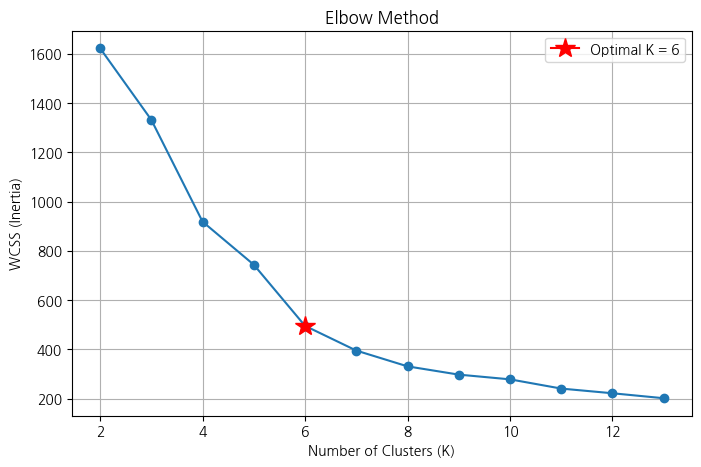

In [ ]:
wcss = elbow_method(df[['경도','위도']])
range_k = list(range(2, 14))  # X축 (K=2부터 13까지)

# Elbow Plot
plt.figure(figsize=(8, 5))
plt.plot(range_k, wcss, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS (Inertia)")
plt.grid(True)

# K=7 강조 
k_star = 7
idx_star = range_k.index(k_star)
wcss_star = wcss[idx_star]

# 빨간 별표 표시
plt.plot(k_star, wcss_star, marker='*', color='red', markersize=15, label="Optimal K")
plt.legend()
plt.show()

In [88]:
scaler = MinMaxScaler()
density_weights = scaler.fit_transform(df[['근방가게수']]).flatten()
density_weights

array([0.05187296, 0.63599349, 0.13680782, ..., 0.15350163, 0.1465798 ,
       0.20472313], shape=(400914,))

In [110]:
from sklearn.cluster import MeanShift
X = df[['경도','위도']]
X_idx = np.random.choice(len(X), size=1000, replace=False)
sample_X = X.loc[X_idx]
meanshift = MeanShift(bandwidth=0.05)
meanshift.fit(sample_X)


MeanShift(bandwidth=0.05)

In [111]:
centers = meanshift.cluster_centers_
centers

array([[126.90732262,  37.51433506],
       [127.03558219,  37.51588096],
       [126.96873649,  37.55885378],
       [126.8458954 ,  37.54641175],
       [127.12254428,  37.50687858],
       [127.05277689,  37.64843201]])

In [105]:
num = 6
# kmeans = KMeans(n_clusters=num, init="k-means++", random_state=42)
# # kmeans.fit(X=df[['경도','위도']]) # 가중치 전
# kmeans.fit(X=df[['경도','위도']], sample_weight=density_weights)  #가중치 후 - minmax
# kmeans.fit(X=df[['경도','위도']], sample_weight=df['근방가게수'])  #가중치 후 - 스케일 보정 x
# kmeans.cluster_centers_


from sklearn.cluster import MeanShift

meanshift = MeanShift(bandwidth=0.01)  # bandwidth 조정 필요
meanshift.fit(df[['경도','위도']])
centers = meanshift.cluster_centers_


KeyboardInterrupt: 

In [113]:
num= 6
center_list = [f'중심점{i}' for i in range(1,num+1) ]
center_list

['중심점1', '중심점2', '중심점3', '중심점4', '중심점5', '중심점6']

In [121]:
# df_centers_10 = pd.DataFrame(kmeans.cluster_centers_, columns=['경도','위도'], index=center_list)
df_centers_10 = pd.DataFrame(centers, columns=['경도','위도'], index=center_list)
df_centers_10 = df_centers_10.reset_index()
df_centers_10

,index,경도,위도
0,중심점1,126.907323,37.514335
1,중심점2,127.035582,37.515881
2,중심점3,126.968736,37.558854
3,중심점4,126.845895,37.546412
4,중심점5,127.122544,37.506879
5,중심점6,127.052777,37.648432


In [122]:
from sklearn.neighbors import BallTree

def closest_radian(df1, df2, df2_col, lat_col='위도', lon_col='경도'):
    # 좌표를 라디안으로 변환
    df1_coords = np.radians(df1[[lat_col, lon_col]].to_numpy())
    df2_coords = np.radians(df2[[lat_col, lon_col]].to_numpy())

    # BallTree 생성 (haversine 거리 사용)
    tree = BallTree(df2_coords, metric='haversine')

    # 각 df1 좌표에 대해 가장 가까운 df2 좌표 인덱스 및 거리 추출
    distances, indices = tree.query(df1_coords, k=1)

    # 거리: 라디안 → km (지구 반지름 6371km 사용)
    distances_km = distances.flatten() * 6371

    # 가장 가까운 df2의 특정 컬럼 값 추출
    closest_values = df2.iloc[indices.flatten()][df2_col].reset_index(drop=True)

    # 반환: 거리(km), df2_col
    return distances_km, closest_values

In [123]:
dist, cluster = closest_radian(df, df_centers_10, df2_col='index')

In [124]:
df['중심점거리'] = dist
df['중심점'] = cluster.values


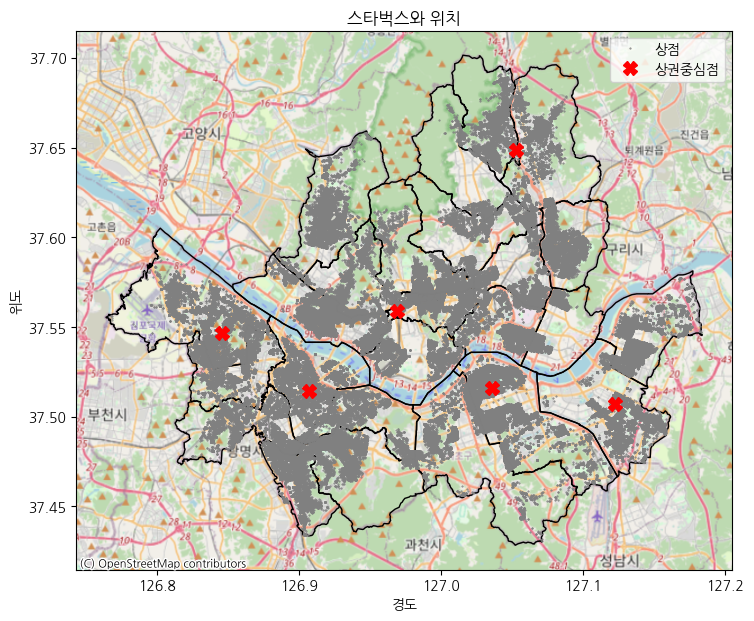

In [125]:
seoul_boundary = gpd.read_file("LARD_ADM_SECT_SGG_11_202502.shp")

seoul_boundary = seoul_boundary.to_crs(epsg=4326)
fig, ax = plt.subplots(figsize=(10, 7))

seoul_boundary.plot(ax=ax, edgecolor="black", facecolor="none")

ctx.add_basemap(ax=ax, 
                crs=seoul_boundary.crs, 
                source=ctx.providers.OpenStreetMap.Mapnik)

df.plot(
    ax=ax,
    x='경도',
    y='위도', 
    linestyle="", 
    color="grey", 
    marker="o", 
    markersize=0.5, 
    label="상점")

df_centers_10.plot(ax=ax,
                  x='경도',
                  y='위도',
                  color='red',
                  linestyle="",
                  marker="X",
                  markersize=10,
                  label='상권중심점')

plt.xlabel('경도')
plt.ylabel('위도')
plt.title('스타벅스와 위치')
plt.show()

## EDA

In [57]:
df.head(1).T

,0
상호명,부동산임대김은숙
상권업종대분류명,음식
상권업종중분류명,비알코올
상권업종소분류명,카페
경도,126.98184
위도,37.58625
근방가게수,638
근방음식점수,153
근방카페수,59
근접역거리,1.123776


In [58]:
df_starbucks = df[df['스타벅스여부'] == 1]
df_starbucks.shape

(461, 33)

In [42]:
age_cols = ['0세_6세', '7세_19세', '20세_25세', '26세_30세', '31세_40세', '41세_50세', '51세_60세', '61세_109세']
age_ratio_cols = [f'ratio_{col}' for col in age_cols]

for (original_col, new_col) in zip(age_cols, age_ratio_cols):
    df_starbucks[new_col] = df_starbucks[original_col] / df_starbucks['계']
    df_starbucks[new_col] = df_starbucks[new_col].round(2)

/var/folders/q2/0w8s3xgj6szdvf0r9_0lyqfr0000gn/T/ipykernel_32071/4038955379.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_starbucks[new_col] = df_starbucks[original_col] / df_starbucks['계']
/var/folders/q2/0w8s3xgj6szdvf0r9_0lyqfr0000gn/T/ipykernel_32071/4038955379.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_starbucks[new_col] = df_starbucks[new_col].round(2)
/var/folders/q2/0w8s3xgj6szdvf0r9_0lyqfr0000gn/T/ipykernel_32071/4038955379.py:5: SettingWithCopyWarning: 
A value is trying to be

In [87]:
df_starbucks.columns

Index(['상호명', '상권업종대분류명', '상권업종중분류명', '상권업종소분류명', '경도', '위도', '근방가게수',
       '근방음식점수', '근방카페수', '근접역거리', '역명', '승차_이용객수', '승차_출근시간대', '승차_퇴근시간대',
       '하차_이용객수', '하차_출근시간대', '하차_퇴근시간대', '계', '0세_6세', '7세_19세', '20세_25세',
       '26세_30세', '31세_40세', '41세_50세', '51세_60세', '61세_109세', '평당거래금액(만원)',
       '스타벅스여부', '가짜인덱스', '시군구명', '읍면동명', '중심점거리', '중심점', 'ratio_0세_6세',
       'ratio_7세_19세', 'ratio_20세_25세', 'ratio_26세_30세', 'ratio_31세_40세',
       'ratio_41세_50세', 'ratio_51세_60세', 'ratio_61세_109세'],
      dtype='object')

In [88]:
df_starbucks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 461 entries, 400453 to 400913
Data columns (total 41 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   상호명             461 non-null    object 
 1   상권업종대분류명        461 non-null    object 
 2   상권업종중분류명        461 non-null    object 
 3   상권업종소분류명        461 non-null    object 
 4   경도              461 non-null    float64
 5   위도              461 non-null    float64
 6   근방가게수           461 non-null    int64  
 7   근방음식점수          461 non-null    int64  
 8   근방카페수           461 non-null    int64  
 9   근접역거리           461 non-null    float64
 10  역명              461 non-null    object 
 11  승차_이용객수         461 non-null    float64
 12  승차_출근시간대        461 non-null    float64
 13  승차_퇴근시간대        461 non-null    float64
 14  하차_이용객수         461 non-null    float64
 15  하차_출근시간대        461 non-null    float64
 16  하차_퇴근시간대        461 non-null    float64
 17  계               461 non-null    

In [89]:
df_starbucks.dropna(axis=0, inplace=True)

/var/folders/q2/0w8s3xgj6szdvf0r9_0lyqfr0000gn/T/ipykernel_22518/1086045859.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_starbucks.dropna(axis=0, inplace=True)


count    461.000000
mean       0.481432
std        0.545394
min        0.020000
25%        0.150000
50%        0.310000
75%        0.600000
max        4.500000
Name: 근접역거리, dtype: float64


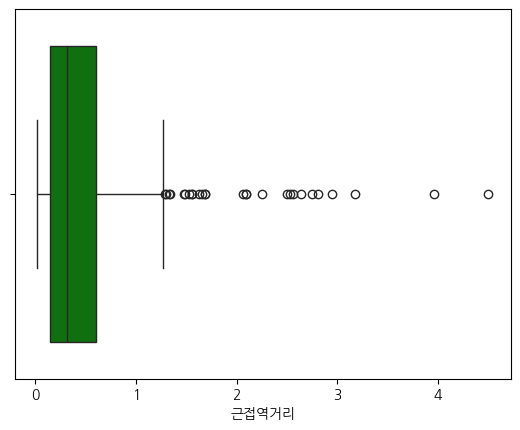

In [90]:
sns.boxplot(data=df_starbucks, x='근접역거리', color='green')
print(df_starbucks['근접역거리'].describe().T)

In [92]:
df_starbucks.columns

Index(['상호명', '상권업종대분류명', '상권업종중분류명', '상권업종소분류명', '경도', '위도', '근방가게수',
       '근방음식점수', '근방카페수', '근접역거리', '역명', '승차_이용객수', '승차_출근시간대', '승차_퇴근시간대',
       '하차_이용객수', '하차_출근시간대', '하차_퇴근시간대', '계', '0세_6세', '7세_19세', '20세_25세',
       '26세_30세', '31세_40세', '41세_50세', '51세_60세', '61세_109세', '평당거래금액(만원)',
       '스타벅스여부', '가짜인덱스', '시군구명', '읍면동명', '중심점거리', '중심점', 'ratio_0세_6세',
       'ratio_7세_19세', 'ratio_20세_25세', 'ratio_26세_30세', 'ratio_31세_40세',
       'ratio_41세_50세', 'ratio_51세_60세', 'ratio_61세_109세'],
      dtype='object')

(0.0, 3.0)

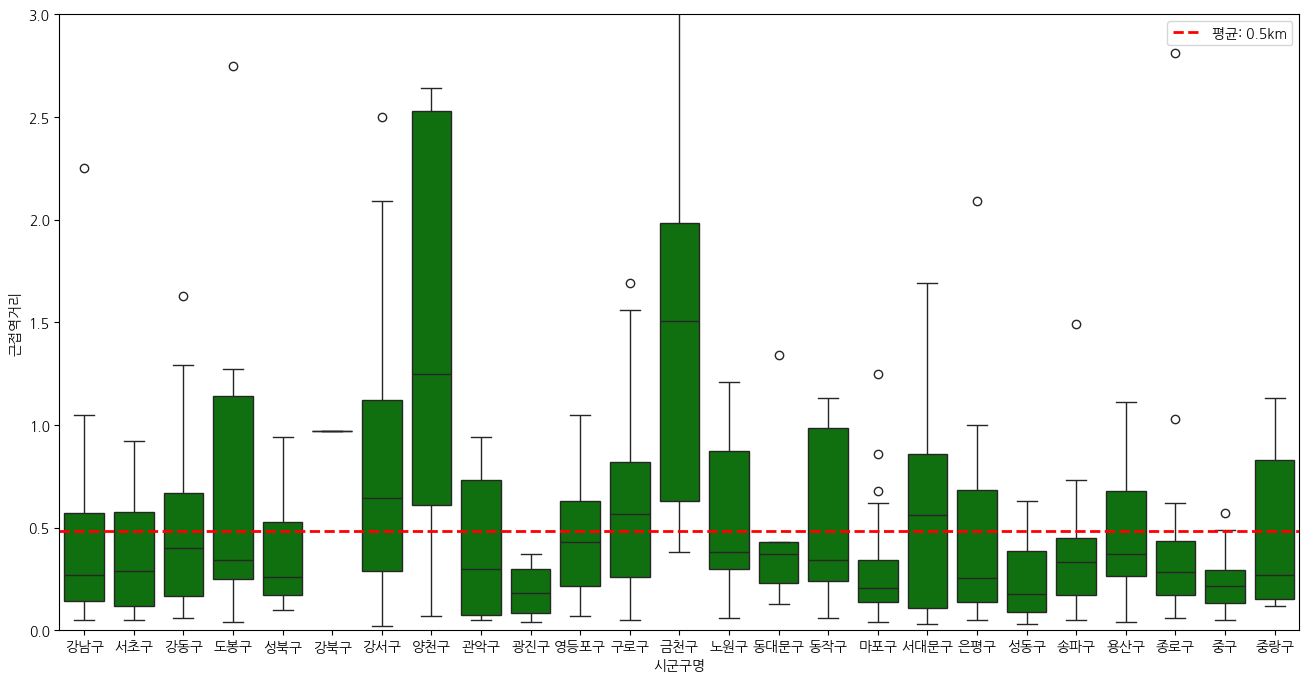

In [106]:
plt.figure(figsize=(16,8))
sns.boxplot(data=df_starbucks, x='시군구명',y='근접역거리', color='green')
mean_station = df_starbucks['근접역거리'].mean()
plt.axhline(mean_station, color='red', linestyle='--', linewidth=2, label=f'평균: {mean_station:.1f}km')
plt.legend()
plt.ylim((0,3))
# print(mean_station)

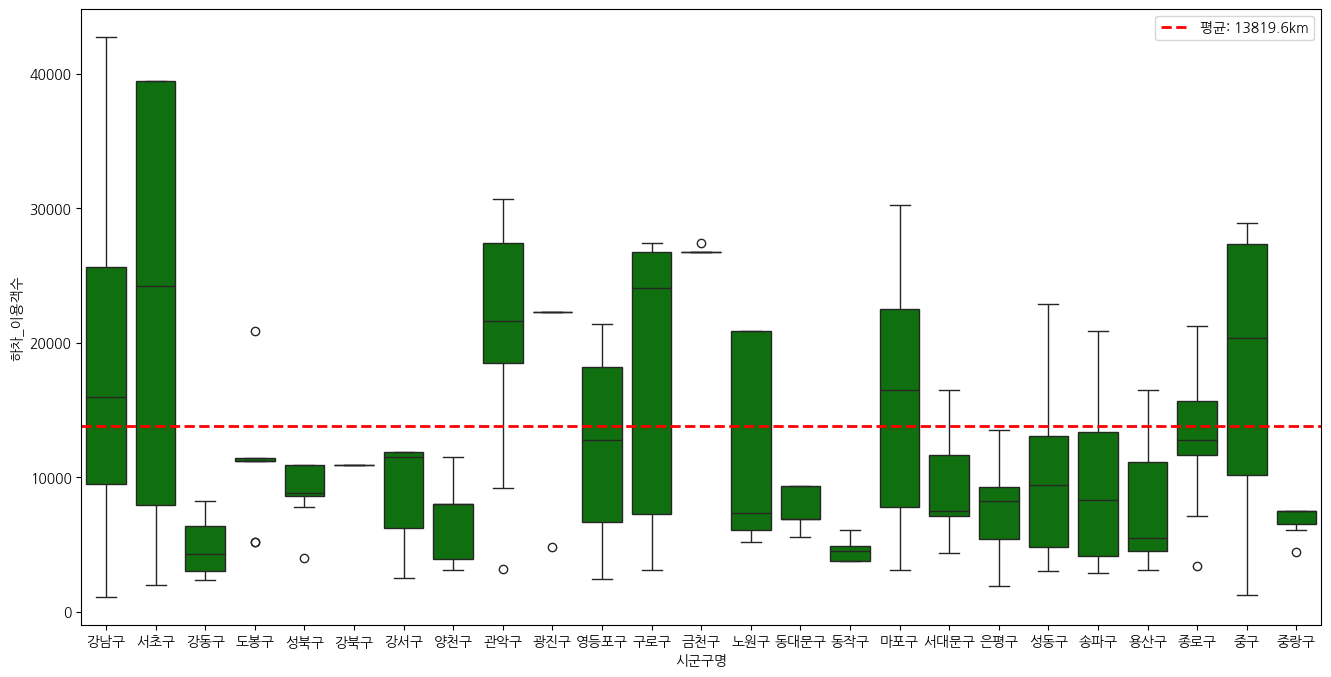

In [120]:
plt.figure(figsize=(16,8))
sns.boxplot(data=df_starbucks, x='시군구명',y='하차_이용객수', color='green')
mean_station = df_starbucks['하차_이용객수'].mean()
plt.axhline(mean_station, color='red', linestyle='--', linewidth=2, label=f'평균: {mean_station:.1f}km')
plt.legend()
# plt.ylim((0,8000))
# print(mean_station)

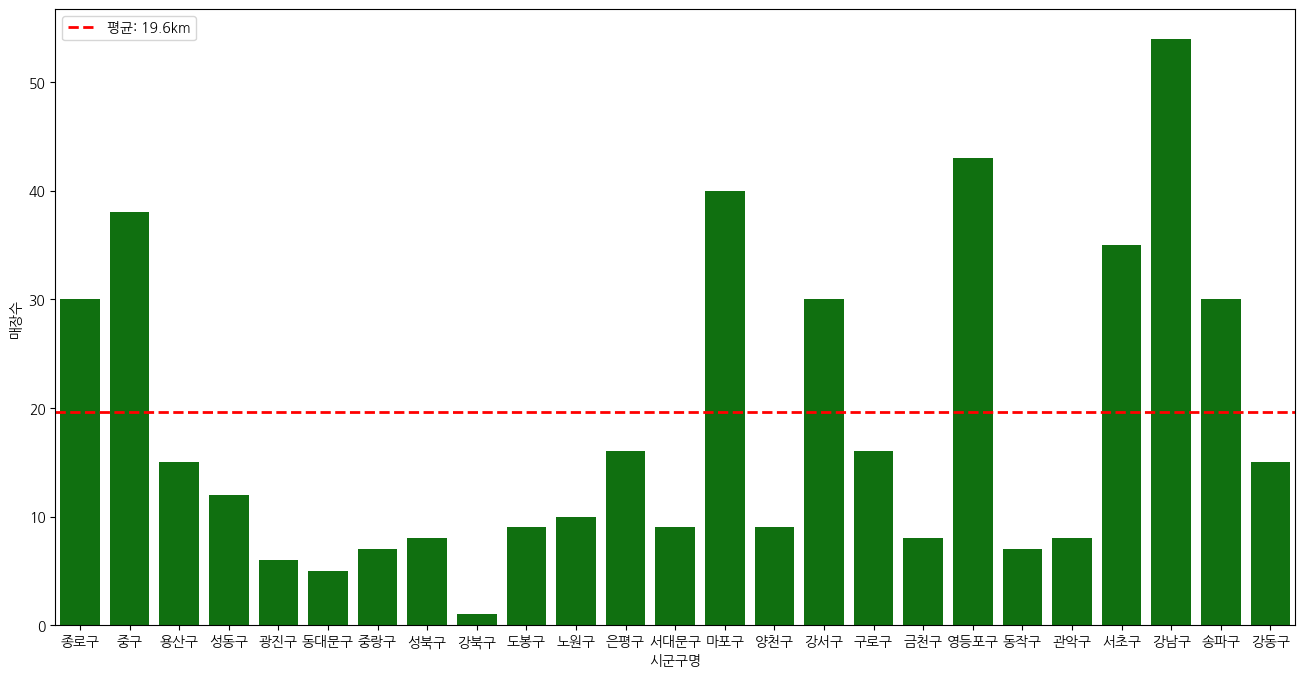

In [144]:
plt.figure(figsize=(16,8))
sns.barplot(data=df_new, x='시군구명',y='매장수', color='green')
mean_station = df_new['매장수'].mean()
plt.axhline(mean_station, color='red', linestyle='--', linewidth=2, label=f'평균: {mean_station:.1f}km')
plt.legend()
# plt.ylim((0,8000))
# print(mean_station)

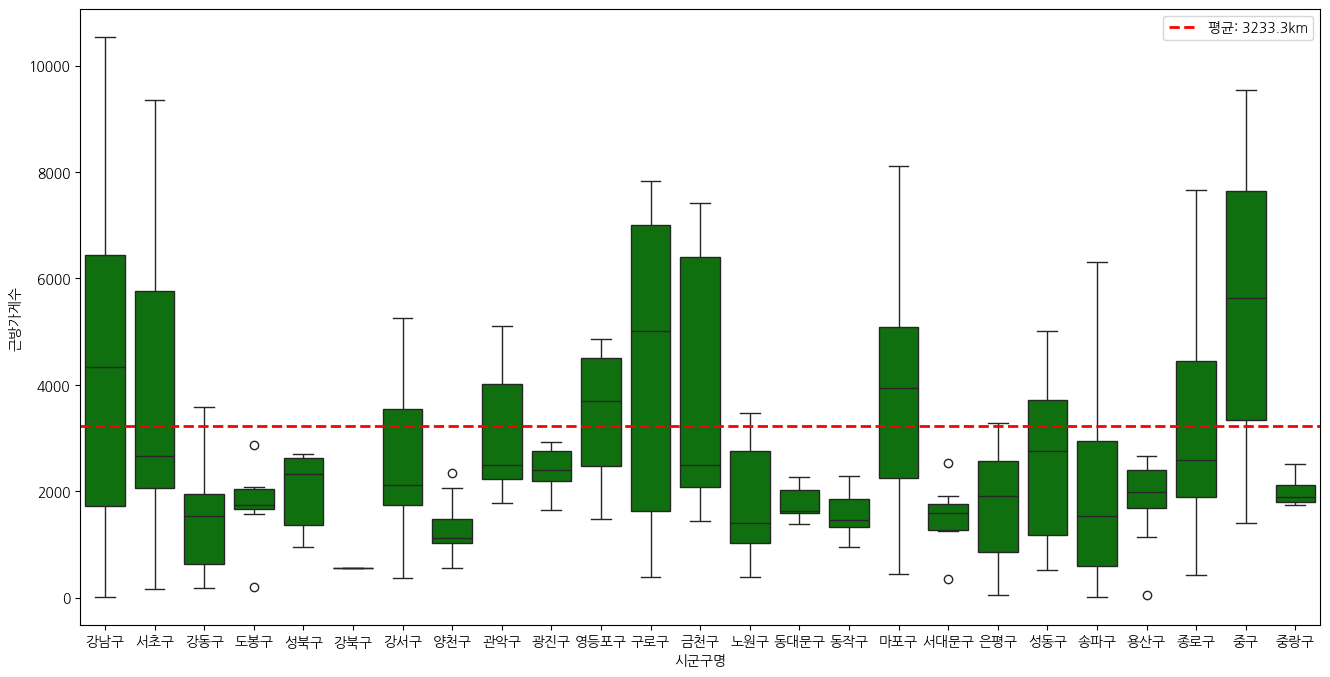

In [139]:
plt.figure(figsize=(16,8))
sns.boxplot(data=df_starbucks, x='시군구명',y='근방가게수', color='green')
mean_station = df_starbucks['근방가게수'].mean()
plt.axhline(mean_station, color='red', linestyle='--', linewidth=2, label=f'평균: {mean_station:.1f}km')
plt.legend()
# plt.ylim((0,8000))
# print(mean_station)

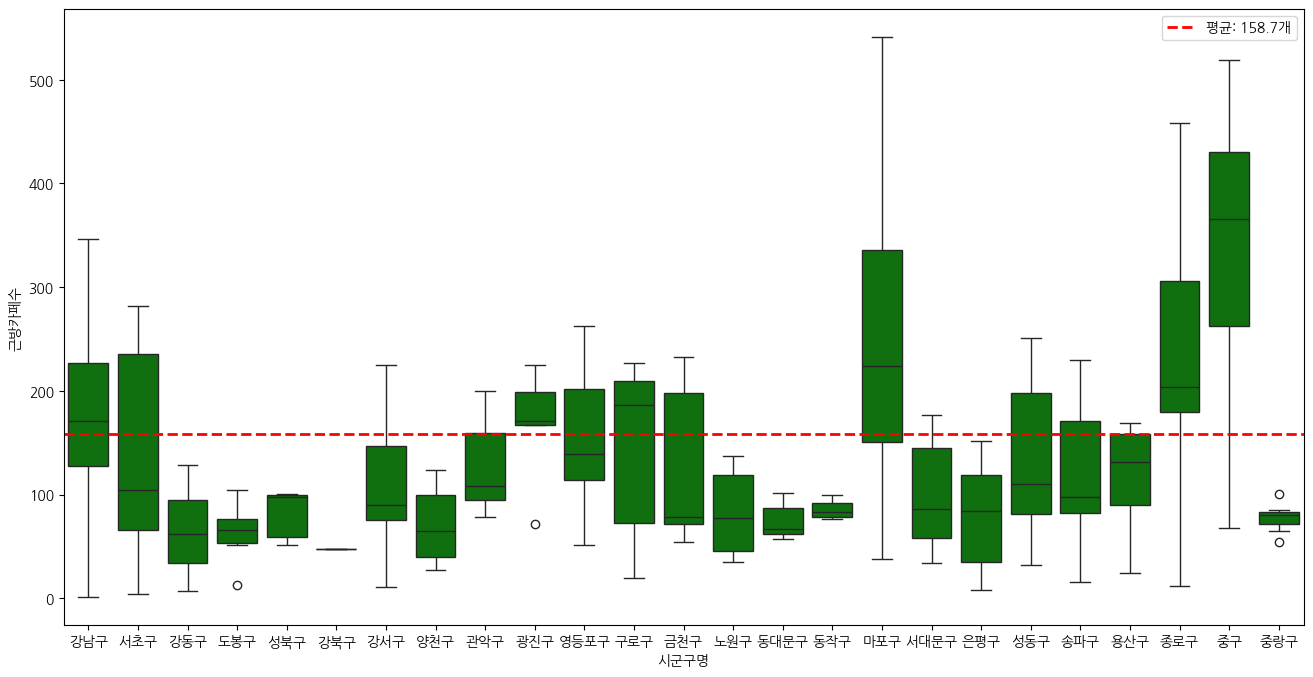

In [142]:
plt.figure(figsize=(16,8))
sns.boxplot(data=df_starbucks, x='시군구명',y='근방카페수', color='green')
mean_station = df_starbucks['근방카페수'].mean()
plt.axhline(mean_station, color='red', linestyle='--', linewidth=2, label=f'평균: {mean_station:.1f}개')
plt.legend()
# plt.ylim((0,8000))
# print(mean_station)

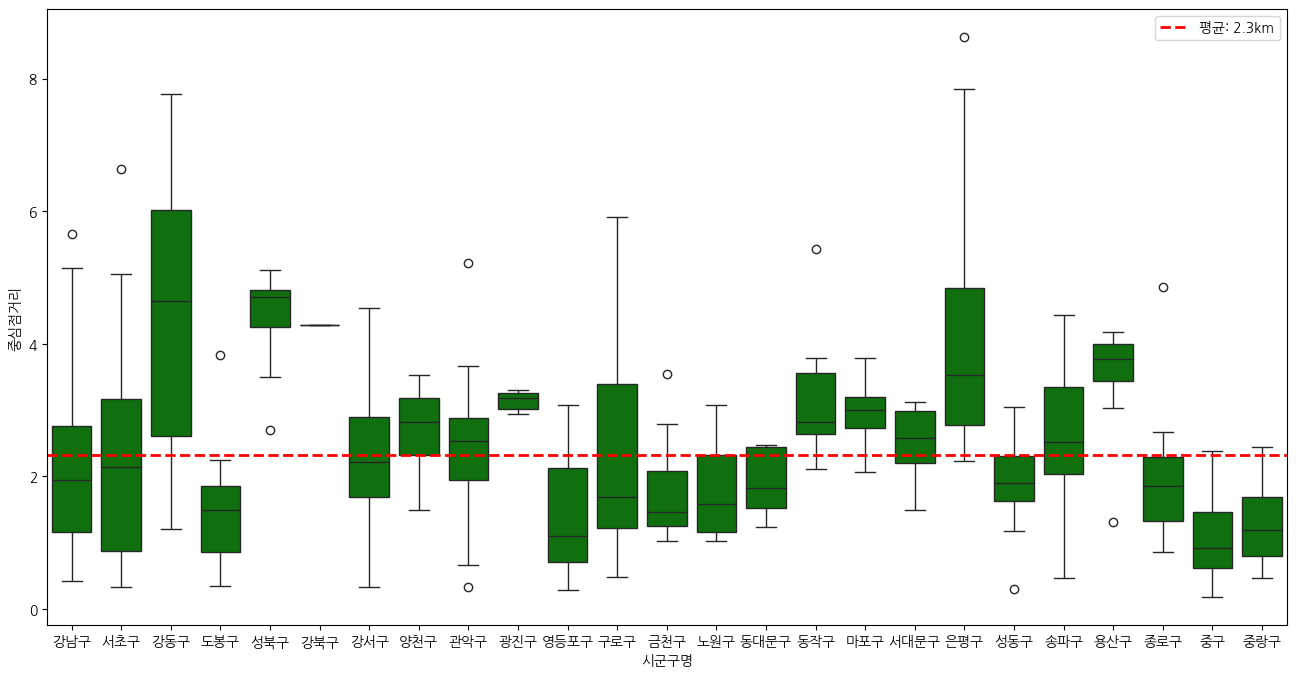

In [138]:
plt.figure(figsize=(16,8))
sns.boxplot(data=df_starbucks, x='시군구명',y='중심점거리', color='green')
mean_station = df_starbucks['중심점거리'].mean()
plt.axhline(mean_station, color='red', linestyle='--', linewidth=2, label=f'평균: {mean_station:.1f}km')
plt.legend()
# plt.ylim((0,8000))
# print(mean_station)

In [135]:
df_new = pd.merge(df_population, df_starbucks.groupby('시군구명').size().reset_index(name='매장수'), on='시군구명')

age_cols = ['0세_6세', '7세_19세', '20세_25세', '26세_30세', '31세_40세', '41세_50세', '51세_60세', '61세_109세']
age_ratio_cols = [f'ratio_{col}' for col in age_cols]

for (original_col, new_col) in zip(age_cols, age_ratio_cols):
    df_new[new_col] = df_new[original_col] / df_new['계']
    df_new[new_col] = df_new[new_col].round(2)
df_new.head(1)


,행정기관코드,기준연월,시도명,시군구명,읍면동명,계,0세_6세,7세_19세,20세_25세,26세_30세,...,가짜인덱스,매장수,ratio_0세_6세,ratio_7세_19세,ratio_20세_25세,ratio_26세_30세,ratio_31세_40세,ratio_41세_50세,ratio_51세_60세,ratio_61세_109세
0,1111051500,2025-05-31,서울특별시,종로구,청운효자동,10978,309,1239,680,797,...,12464,30,0.03,0.11,0.06,0.07,0.14,0.16,0.17,0.26


<Axes: xlabel='ratio_0세_6세', ylabel='매장수'>

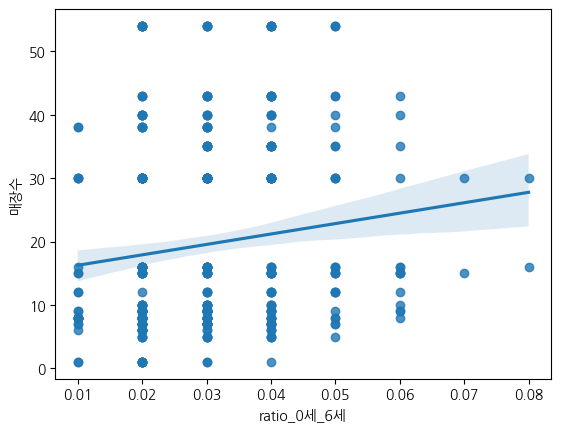

In [136]:
# sns.swarmplot(data=df_starbucks, x='시군구명', y='ratio_31세_40세', jitter=True)
sns.regplot(data=df_new, x='ratio_0세_6세', y='매장수')



In [ ]:
plt.figure(figsize=(16,8))
sns.boxplot(data=df_starbucks, x='시군구명',y='하차_출근시간대', color='green')
mean_station = df_starbucks['하차_출근시간대'].mean()
plt.axhline(mean_station, color='red', linestyle='--', linewidth=2, label=f'평균: {mean_station:.1f}km')
plt.legend()
# plt.ylim((0,8000))
# print(mean_station)

In [ ]:
plt.figure(figsize=(16,8))
sns.boxplot(data=df_starbucks, x='시군구명',y='승하차인구', color='green')
mean_station = df_starbucks['평당거래금액(만원)'].mean()
plt.axhline(mean_station, color='red', linestyle='--', linewidth=2, label=f'평균: {mean_station:.1f}km')
plt.legend()
plt.ylim((0,8000))
# print(mean_station)

In [108]:
df_starbucks.columns

Index(['상호명', '상권업종대분류명', '상권업종중분류명', '상권업종소분류명', '경도', '위도', '근방가게수',
       '근방음식점수', '근방카페수', '근접역거리', '역명', '승차_이용객수', '승차_출근시간대', '승차_퇴근시간대',
       '하차_이용객수', '하차_출근시간대', '하차_퇴근시간대', '계', '0세_6세', '7세_19세', '20세_25세',
       '26세_30세', '31세_40세', '41세_50세', '51세_60세', '61세_109세', '평당거래금액(만원)',
       '스타벅스여부', '가짜인덱스', '시군구명', '읍면동명', '중심점거리', '중심점', 'ratio_0세_6세',
       'ratio_7세_19세', 'ratio_20세_25세', 'ratio_26세_30세', 'ratio_31세_40세',
       'ratio_41세_50세', 'ratio_51세_60세', 'ratio_61세_109세'],
      dtype='object')

In [14]:
cond = (df['스타벅스여부'] == 0) & (df['상권업종소분류명']=='카페')
df_cafe = df[cond]
df_cafe.shape

(16827, 30)

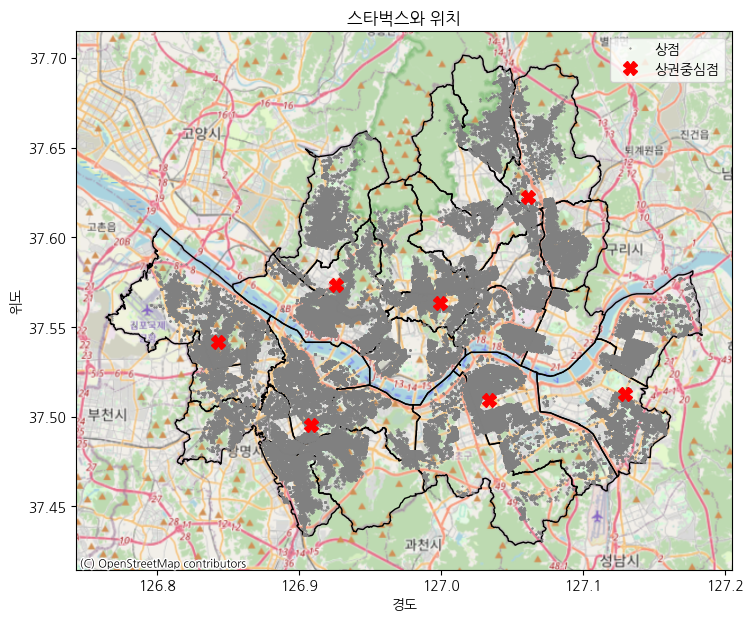

In [48]:
seoul_boundary = gpd.read_file("LARD_ADM_SECT_SGG_11_202502.shp")


# 좌표계 통합 필요
## shapefile 좌표계(crs): EPSG:5179 (TM좌표계, 미터단위)
## housing 데이터: EPSG:4326 (WGS84, 위경도 단위)
seoul_boundary = seoul_boundary.to_crs(epsg=4326)
fig, ax = plt.subplots(figsize=(10, 7))

seoul_boundary.plot(ax=ax, edgecolor="black", facecolor="none")

# df_seoul.plot(ax=ax, kind='scatter', x='경도', y='위도', grid=True, cmap="jet", alpha=0.5)

ctx.add_basemap(ax=ax, 
                crs=seoul_boundary.crs, 
                source=ctx.providers.OpenStreetMap.Mapnik)

# df_megamgc.plot(
#     ax=ax,
#     x='경도',
#     y='위도', 
#     linestyle="", 
#     color="black", 
#     marker="*", 
#     markersize=10, 
#     label="메가커피")


# df_starbucks.plot(
#     ax=ax,
#     x='경도',
#     y='위도', 
#     linestyle="", 
#     color="green", 
#     marker="*", 
#     markersize=10, 
#     label="스타벅스")

df.plot(
    ax=ax,
    x='경도',
    y='위도', 
    linestyle="", 
    color="grey", 
    marker="o", 
    markersize=0.5, 
    label="상점")

df_centers_10.plot(ax=ax,
                  x='경도',
                  y='위도',
                  color='red',
                  linestyle="",
                  marker="X",
                  markersize=10,
                  label='상권중심점')

plt.xlabel('경도')
plt.ylabel('위도')
plt.title('스타벅스와 위치')
plt.show()

In [150]:
lat_mean = df['위도'].mean()
long_mean = df['경도'].mean()

from folium import Marker
m = folium.Map(
    location=[lat_mean, long_mean],
    zoom_start=10)

# icons = ["glyphicon-cloud", "glyphicon-star", "glyphicon-home", "glyphicon-tree-conifer",
#          "glyphicon-tree-deciduous", "glyphicon-fire", "glyphicon-flash", "glyphicon-road",
#          "glyphicon-cutlery", "glyphicon-plane", "glyphicon-phone", "glyphicon-globe",
#          "glyphicon-heart", "glyphicon-info-sign", "glyphicon-exclamation-sign", 
#          "glyphicon-thumbs-up", "glyphicon-thumbs-down", "glyphicon-fullscreen", 
#          "glyphicon-screenshot", "glyphicon-cloud-upload", "glyphicon-cloud-download"]

for _, row in df_centers_10.iterrows():
    Marker(
        location = [row['위도'], row['경도']],
        icon=folium.Icon(icon='glyphicon-asterisk',
                         color='black',
                         icon_color='red',
                         )
    ).add_to(m)

# for _, row in df_starbucks.iterrows():
#     Marker(
#         location = [row['위도'], row['경도']],
#         icon=folium.Icon(icon='glyphicon-asterisk',
#                          color='white',
#                          icon_color='green',
#                          )
#     ).add_to(m)


m

<Axes: xlabel='경도', ylabel='위도'>

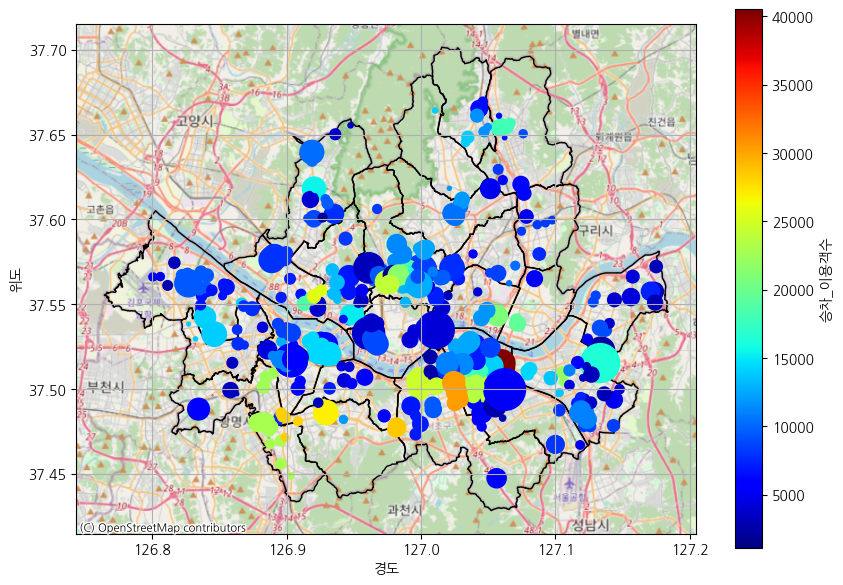

In [165]:
seoul_boundary = gpd.read_file("LARD_ADM_SECT_SGG_11_202502.shp")
seoul_boundary = seoul_boundary.to_crs(epsg=4326)


fig, ax = plt.subplots(figsize=(10, 7))

seoul_boundary.plot(ax=ax, edgecolor="black", facecolor="none")


ctx.add_basemap(ax=ax, 
                crs=seoul_boundary.crs, 
                source=ctx.providers.OpenStreetMap.Mapnik)



df_starbucks.plot(
    ax=ax,
    kind='scatter',
    x='경도', y='위도',
    s=df_starbucks['평당거래금액(만원)']/10,
    c='승차_이용객수', cmap='jet', colorbar=True, grid=True)